# Discussion of Mean-Variance Optimization
## in the Context of Homework 1: Harvard's Endowment
### Mark Hendricks

This discussion focuses particularly on the optimization of excess returns, (as raised in section 3 of the homework,) with only a brief mention of the optimization of total returns (as raise din section 2 of the homework.)

See the TA homework solution for more explicit discussion of the homework solutions.

## Setup

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## Data

In [2]:
filepath_data = '../data/multi_asset_etf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.set_index('ticker',inplace=True)

In [3]:
rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('Date',inplace=True)
rets.drop(columns=['SHV'])

retsx = pd.read_excel(filepath_data,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
symbol_list = info.index.drop('SHV')
rets = rets[symbol_list]
retsx = retsx[symbol_list]

In [4]:
info

,shortName,quoteType,currency,volume,totalAssets,longBusinessSummary
ticker,,,,,,
SPY,SPDR S&P 500,ETF,USD,101107853,358229114880,The Trust seeks to achieve its investment obje...
EFA,iShares MSCI EAFE ETF,ETF,USD,33352872,43798241280,The fund generally will invest at least 80% of...
EEM,iShares MSCI Emerging Index Fun,ETF,USD,47539498,25870192640,The fund generally will invest at least 80% of...
PSP,Invesco Global Listed Private E,ETF,USD,120371,171932880,The fund generally will invest at least 90% of...
QAI,IQ Hedge MultiIQ Hedge Multi-St,ETF,USD,138713,707315584,"The fund is a ""fund of funds"" which means it i..."
HYG,iShares iBoxx $ High Yield Corp,ETF,USD,48935762,12276870144,The underlying index is a rules-based index co...
DBC,Invesco DB Commodity Index Trac,ETF,USD,2314311,3708376064,The fund pursues its investment objective by i...
IYR,iShares U.S. Real Estate ETF,ETF,USD,12097258,4077254400,The fund seeks to track the investment results...
IEF,iShares 7-10 Year Treasury Bond,ETF,USD,7992450,23017226240,The underlying index measures the performance ...


In [5]:
retsx

,SPY,EFA,EEM,PSP,QAI,HYG,DBC,IYR,IEF,BWX,TIP
Date,,,,,,,,,,,
2009-04-30,0.0988,0.1146,0.1550,0.2296,0.0223,0.1379,-0.0016,0.2956,-0.0280,0.0084,-0.0185
2009-05-31,0.0589,0.1324,0.1599,0.0544,0.0283,0.0290,0.1631,0.0232,-0.0203,0.0541,0.0204
2009-06-30,-0.0013,-0.0146,-0.0231,0.0448,-0.0040,0.0329,-0.0269,-0.0255,-0.0062,0.0045,0.0014
2009-07-31,0.0746,0.1004,0.1102,0.1433,0.0154,0.0692,0.0186,0.1058,0.0083,0.0313,0.0009
2009-08-31,0.0365,0.0446,-0.0136,0.0330,-0.0046,-0.0174,-0.0408,0.1315,0.0072,0.0072,0.0080
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-30,-0.0875,-0.0671,-0.0611,-0.1254,-0.0331,-0.0415,0.0567,-0.0410,-0.0420,-0.0694,-0.0215
2022-05-31,0.0016,0.0193,0.0055,0.0144,-0.0047,0.0156,0.0455,-0.0451,0.0055,0.0048,-0.0106
2022-06-30,-0.0817,-0.0869,-0.0508,-0.1317,-0.0329,-0.0697,-0.0742,-0.0682,-0.0079,-0.0457,-0.0304


# Functions that will be useful
## Basic performance metrics

In [6]:
def performanceMetrics(returns,annualization=1):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()

    return metrics

## Tangency portfolio

In [7]:
def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns)

# Section 3 - Excess Returns
## 3.1.1

In [8]:
mets = performanceMetrics(retsx,annualization=12)
mets.sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Min,Max
SPY,0.1456,0.1453,1.0026,-0.1290,0.1268
IYR,0.1455,0.1847,0.7875,-0.2005,0.2956
HYG,0.0669,0.0897,0.7462,-0.1044,0.1379
TIP,0.0303,0.0477,0.6358,-0.0418,0.0422
PSP,0.1286,0.2218,0.5800,-0.2789,0.2296
EFA,0.0765,0.1623,0.4712,-0.1452,0.1429
QAI,0.0182,0.0492,0.3703,-0.0605,0.0340
IEF,0.0212,0.0594,0.3567,-0.0440,0.0461
EEM,0.0680,0.1921,0.3539,-0.1791,0.1628
DBC,0.0342,0.1807,0.1893,-0.1776,0.1631


## 3.1.2

MIN Correlation pair is ('DBC', 'IEF')
MAX Correlation pair is ('PSP', 'EFA')


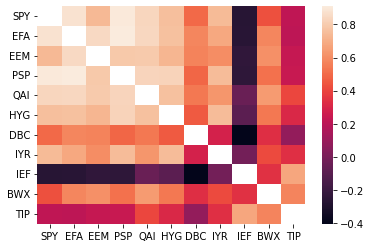

In [9]:
corrmat = retsx.corr()
#ignore self-correlation
corrmat[corrmat==1] = None
sns.heatmap(corrmat)

corr_rank = corrmat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

### TIPS

TIPS have one of the highest Sharpe ratios--they have a low mean, but a very low volatility. Furthermore, they have outperformed Domestic bonds in terms of mean and in terms of volatility.

Notably, TIPS have very low correlation to the other assets--including relatively low coorrelation to IEF (Domestic Bonds). In the correlation heat map above, we see that TIPS provide a great deal of diversification to all assets except IEF, to which they still provide some diversification.

## 3.1.3 The Tangency and the MV Frontier

In [10]:
wts = pd.DataFrame(index=retsx.columns)
wts['tangency'] = tangency_weights(retsx)
wts['tangency ex tips'] = tangency_weights(retsx.drop(columns=['TIP']))
wts.loc['TIP','tangency ex tips'] = 0
wts['tangency tot'] = tangency_weights(rets)
retsx_tan = pd.DataFrame(retsx @ wts['tangency'],columns=['tangency'])
retsx_tan_extips = pd.DataFrame(retsx @ wts['tangency ex tips'],columns=['tangency ex tips'])
rets_tan = pd.DataFrame(rets @ wts['tangency tot'],columns=['tangency tot'])

performanceMetrics(pd.concat([retsx,retsx_tan,retsx_tan_extips,rets_tan],axis=1),annualization=12)

,Mean,Vol,Sharpe,Min,Max
SPY,0.1456,0.1453,1.0026,-0.1290,0.1268
EFA,0.0765,0.1623,0.4712,-0.1452,0.1429
EEM,0.0680,0.1921,0.3539,-0.1791,0.1628
PSP,0.1286,0.2218,0.5800,-0.2789,0.2296
QAI,0.0182,0.0492,0.3703,-0.0605,0.0340
HYG,0.0669,0.0897,0.7462,-0.1044,0.1379
DBC,0.0342,0.1807,0.1893,-0.1776,0.1631
IYR,0.1455,0.1847,0.7875,-0.2005,0.2956
IEF,0.0212,0.0594,0.3567,-0.0440,0.0461
BWX,0.0000,0.0783,0.0000,-0.0694,0.0612


## For Illustration

In [11]:
import os
import sys
sys.path.insert(0, '../cmds')
from portfolio import MVweights

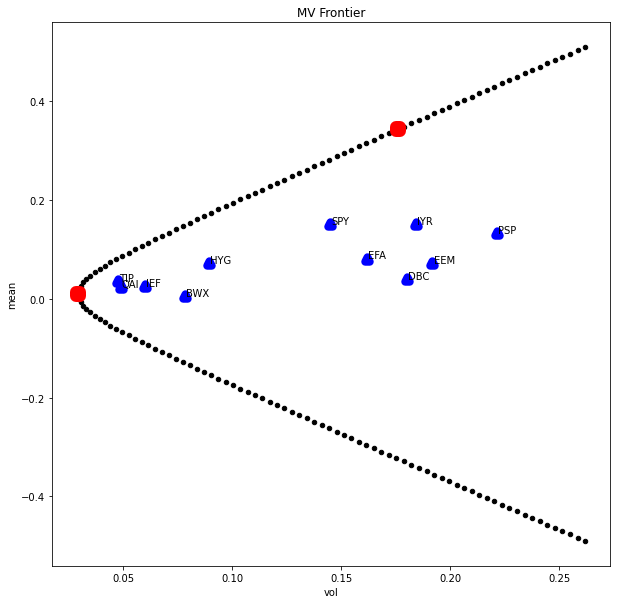

In [12]:
omega_tan = tangency_weights(rets)
rets_adj = rets - rets.mean() + 1
omega_gmv = tangency_weights(rets_adj)
omega = pd.concat([omega_tan,omega_gmv],axis=1)
omega.columns = ['tangency','gmv']

delta_grid = np.linspace(-1.5,1.5,150)
mv_frame = pd.DataFrame(columns=['mean','vol'],index=delta_grid)
for i, delta in enumerate(delta_grid):
    omega_mv = delta * omega_tan + (1-delta) * omega_gmv
    rets_p = rets @ omega_mv
    mv_frame['mean'].iloc[i] = rets_p.mean().values[0] * 12
    mv_frame['vol'].iloc[i] = rets_p.std().values[0] * np.sqrt(12)
    
rets_special = pd.DataFrame(index=rets.index)
rets_special['tan'] = rets @ omega_tan.values
rets_special['gmv'] = rets @ omega_gmv.values

mv_assets = pd.concat([rets.mean() * 12,rets.std() * np.sqrt(12)],axis=1)
mv_special = pd.concat([rets_special.mean() * 12, rets_special.std() * np.sqrt(12)],axis=1)
mv_assets.columns = ['mean','vol']
mv_special.columns = ['mean','vol']

ax = mv_frame.plot.scatter(x='vol',y='mean', c='k', figsize=(10,10), title='MV Frontier')
mv_assets.plot.scatter(x='vol',y='mean',ax=ax, c='b', marker='^', linewidth=8)
mv_special.plot.scatter(x='vol',y='mean',ax=ax, c='r', marker='s', linewidth=12)

for i in range(mv_assets.shape[0]):
    plt.text(x=mv_assets['vol'][i]+.0005, y=mv_assets['mean'][i]+.0005, s=mv_assets.index[i])

### How similar are tangency to 0 (in total returns) and tangency to risk-free (excess returns)?

In [13]:
comp = pd.concat([wts['tangency'], omega['tangency']],axis=1)
comp.columns = ['tan.riskfree','tan.zero']
comp

print(f'Correlation between tangency weights in total and excess returns is {comp.corr().values[0,1]:.4f}.')

Correlation between tangency weights in total and excess returns is 0.9980.


Correlation between the weights are very similar.

But the excess return tangency weights are much larger magnitude, (nearly double,) leading to similar Sharpe but at much higher mean and vol (nearly double.)

## 3.1.4 The Allocation

In [14]:
target_mean = .01

mu_tan = retsx.mean() @ wts['tangency']
delta = target_mean / mu_tan

wts['optimal'] = wts['tangency'] * delta

# list the assets sharpe ratios in a column to demonstrate not highly correlated with optimal weights
comp = pd.concat([wts[['optimal']],mets['Sharpe']],axis=1)
corr_sharpe_wts = comp.corr().values[0][1]

comp.sort_values('optimal',ascending=False)

,optimal,Sharpe
SPY,0.8814,1.0026
IEF,0.8642,0.3567
HYG,0.3616,0.7462
TIP,0.2179,0.6358
EEM,0.1341,0.3539
DBC,0.0843,0.1893
EFA,-0.0481,0.4712
IYR,-0.1082,0.7875
PSP,-0.1643,0.5800
BWX,-0.4540,0.0000


In [15]:
print(f'Total share in risky assets is {delta:.4f}.\nTotal share in risk-free asset is {1-delta:.4f}')
print(f'Correlation between an assets Sharpe ratio and its weight is {corr_sharpe_wts:.4f}.')

Total share in risky assets is 0.1801.
Total share in risk-free asset is 0.8199
Correlation between an assets Sharpe ratio and its weight is 0.4057.


## 3.1.5 Simple Portfolios

In [16]:
wts['equal'] = 1/len(retsx.columns)
wts['parity'] = 1/retsx.std()
# rescale these to hit the target mean
wts[['equal','parity']] *= target_mean / (retsx.mean()@wts[['equal','parity']])

wts

,tangency,tangency ex tips,tangency tot,optimal,equal,parity
SPY,4.8947,5.7002,2.4306,0.8814,0.1633,0.1504
EFA,-0.2673,-0.4222,-0.1171,-0.0481,0.1633,0.1346
EEM,0.7445,0.9005,0.3398,0.1341,0.1633,0.1137
PSP,-0.9122,-0.9909,-0.5131,-0.1643,0.1633,0.0985
QAI,-8.8233,-10.0070,-3.9552,-1.5889,0.1633,0.4442
HYG,2.0079,2.2734,1.0705,0.3616,0.1633,0.2435
DBC,0.4684,0.6334,0.2392,0.0843,0.1633,0.1209
IYR,-0.6009,-0.6577,-0.3078,-0.1082,0.1633,0.1182
IEF,4.7993,6.4299,2.4580,0.8642,0.1633,0.3678
BWX,-2.5211,-2.8597,-1.3352,-0.4540,0.1633,0.2790


In [17]:
mets_full = performanceMetrics(retsx @ wts,annualization=12)
mets_full

,Mean,Vol,Sharpe,Min,Max
tangency,0.6664,0.3454,1.9291,-0.1708,0.3827
tangency ex tips,0.7638,0.3976,1.9209,-0.1924,0.4161
tangency tot,0.3382,0.1759,1.9226,-0.0766,0.2003
optimal,0.1200,0.0622,1.9291,-0.0308,0.0689
equal,0.1200,0.1801,0.6662,-0.2103,0.1656
parity,0.1200,0.1730,0.6938,-0.1917,0.1324


## 3.1.6 Dropping TIPS

In [18]:
wts

,tangency,tangency ex tips,tangency tot,optimal,equal,parity
SPY,4.8947,5.7002,2.4306,0.8814,0.1633,0.1504
EFA,-0.2673,-0.4222,-0.1171,-0.0481,0.1633,0.1346
EEM,0.7445,0.9005,0.3398,0.1341,0.1633,0.1137
PSP,-0.9122,-0.9909,-0.5131,-0.1643,0.1633,0.0985
QAI,-8.8233,-10.0070,-3.9552,-1.5889,0.1633,0.4442
HYG,2.0079,2.2734,1.0705,0.3616,0.1633,0.2435
DBC,0.4684,0.6334,0.2392,0.0843,0.1633,0.1209
IYR,-0.6009,-0.6577,-0.3078,-0.1082,0.1633,0.1182
IEF,4.7993,6.4299,2.4580,0.8642,0.1633,0.3678
BWX,-2.5211,-2.8597,-1.3352,-0.4540,0.1633,0.2790


## 3.1.7 Out-of-Sample Testing

In [19]:
retsx_IS = retsx.loc[:'2021']
retsx_OOS = retsx.loc['2022':]
wts_IS = tangency_weights(retsx.loc[:'2021'])
wts_IS.columns = ['mv']

wts_IS['equal'] = 1/len(retsx_IS.columns)
wts_IS['parity'] = 1/retsx_IS.std()
# rescale these to hit the target mean
wts_IS *= target_mean / (retsx_IS.mean()@ wts_IS)

wts_IS

,mv,equal,parity
SPY,0.7846,0.1348,0.1205
EFA,-0.0473,0.1348,0.1047
EEM,0.0225,0.1348,0.0866
PSP,-0.0459,0.1348,0.0786
QAI,-1.2867,0.1348,0.3530
HYG,0.4341,0.1348,0.1976
DBC,-0.0064,0.1348,0.0941
IYR,-0.1744,0.1348,0.0929
IEF,0.8267,0.1348,0.2978
BWX,-0.1667,0.1348,0.2283


In [20]:
port_IS = retsx_IS @ wts_IS

performanceMetrics(port_IS,annualization=12)

,Mean,Vol,Sharpe,Min,Max
mv,0.1200,0.0533,2.2529,-0.0192,0.0621
equal,0.1200,0.1454,0.8255,-0.1737,0.1367
parity,0.1200,0.1307,0.9182,-0.1519,0.1044


In [21]:
port_OOS = retsx_OOS @ wts_IS

performanceMetrics(port_OOS,annualization=12)

,Mean,Vol,Sharpe,Min,Max
mv,-0.1056,0.1512,-0.6983,-0.0564,0.0820
equal,-0.3009,0.1751,-1.7183,-0.0917,0.0657
parity,-0.3701,0.1969,-1.8793,-0.0966,0.0789


### Why does the MV Portfolio do worse?
#### It has a huge position in SPY, and SPY was the best performing asset in 2021!

In [22]:
performanceMetrics(retsx_OOS,annualization=12).sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Min,Max
DBC,0.3733,0.1967,1.8975,-0.0742,0.0921
SPY,-0.2314,0.2106,-1.0987,-0.0875,0.0912
HYG,-0.1726,0.1432,-1.2055,-0.0697,0.0661
IYR,-0.2710,0.2214,-1.2238,-0.0815,0.0877
TIP,-0.1038,0.0815,-1.2725,-0.0304,0.0422
EFA,-0.3058,0.1625,-1.8821,-0.0869,0.0508
IEF,-0.1720,0.0865,-1.9896,-0.0420,0.0287
PSP,-0.5738,0.2811,-2.0412,-0.1317,0.1081
QAI,-0.1368,0.0589,-2.3209,-0.0331,0.0179
BWX,-0.3319,0.1052,-3.1547,-0.0694,0.0196


## 3.2

### Suppose TIPS had a slightly different mean return than the in-sample estimate

* Would the weights change much?
* Would the MV frontier change much?

In [23]:
retsx_adj = retsx.copy()
retsx_adj['TIP'] -= .0015

wts_adj = wts[['tangency','optimal']].copy()
wts_adj['tangency adj'] = tangency_weights(retsx_adj)
retsx_tan_adj = pd.DataFrame(retsx_adj @ wts_adj['tangency adj'],columns=['tangency adj'])

mu_adj = retsx_adj.mean()
mu_tan_adj = mu_adj @ wts_adj['tangency adj']
delta_adj = target_mean / mu_tan

wts_adj['optimal adj'] = wts_adj['tangency adj'] * delta_adj

wts_adj

,tangency,optimal,tangency adj,optimal adj
SPY,4.8947,0.8814,10.5418,1.8984
EFA,-0.2673,-0.0481,-1.3533,-0.2437
EEM,0.7445,0.1341,1.8381,0.3310
PSP,-0.9122,-0.1643,-1.4642,-0.2637
QAI,-8.8233,-1.5889,-17.1216,-3.0832
HYG,2.0079,0.3616,3.8690,0.6967
DBC,0.4684,0.0843,1.6255,0.2927
IYR,-0.6009,-0.1082,-0.9992,-0.1799
IEF,4.7993,0.8642,16.2311,2.9229
BWX,-2.5211,-0.4540,-4.8946,-0.8814


In [24]:
mets_adj = performanceMetrics(retsx_adj @ wts_adj[['tangency adj','optimal adj']], annualization=12)
pd.concat([mets_full.loc[['tangency','optimal']],mets_adj])

,Mean,Vol,Sharpe,Min,Max
tangency,0.6664,0.3454,1.9291,-0.1708,0.3827
optimal,0.1200,0.0622,1.9291,-0.0308,0.0689
tangency adj,1.4801,0.7448,1.9872,-0.3949,0.6424
optimal adj,0.2665,0.1341,1.9872,-0.0711,0.1157


In [25]:
tips_se = retsx['TIP'].std()/np.sqrt(retsx.shape[0])
print(f'Standard error of mean of TIPS is equal to {tips_se:0.4f}')
print(f'Proposed adjustment to mean of TIPS is {.01/12 : 0.4f}')

Standard error of mean of TIPS is equal to 0.0011
Proposed adjustment to mean of TIPS is  0.0008
